# Calibration notebook

About this notebook, we've divided it into the 4 following parts:

1. **Predictions loading**: We load a CSV file with the predictions concerning the model to evaluate.
2. **Evaluations loading**: We load a CSV file with the evaluations concerning the model to evaluate.
3. **Calibrator fit**: After specifying the target measure of interest (e.g., f1-score, accuracy), we fit some calibration models to the transformed predictions using the aforementioned predictions. This introduces some limitations in terms of the granularity of the metrics -- are we fitting it into a discrete/categorical or continuous variable?
5. **Dump calibrated predictions** and **model**: After fitting the model we store the model checkpoint as well as its predictions in the specified folders.


**Note**: We assume that all of these files will have a set of index columns through which we can jointly align them.


In [1]:
OUTPUT_DIR = "../outputs"

# name of the dataset to preprocess
DATASET_NAME, SPLIT_NAME = "squad", "validation"
# DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
# DATASET_NAME, SPLIT_NAME = "narrativeqa", "test_5k_sample_seed_2022"


IS_LOCAL_FS_DATASET = True \
    if (DATASET_NAME in ("newsqa", ) or SPLIT_NAME in ("test_5k_sample_seed_2022",)) \
    else False

if isinstance(DATASET_NAME, tuple):
    NORMALIZED_DATASET_NAME = "".join(DATASET_NAME)
else:
    NORMALIZED_DATASET_NAME = DATASET_NAME
    
# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------
BASE_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}"
ROOT_DIR = f"{OUTPUT_DIR}/results/{NORMALIZED_DATASET_NAME}/{SPLIT_NAME}"

CALIB_ROOT_DIR = f"{ROOT_DIR}/calib"

# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip",
   "encoding": "utf-8",
}
    
# ---------------------------------------------------------------------------
# Data columns
# ---------------------------------------------------------------------------
ID_COLS = ["example_id", "answer_id"]
UNIQUE_ID_COL = ID_COLS[0]

## (optional) Split the matrix in calibration and test set

If you dont need this step, feel free to skip this section.

In [2]:
from sklearn.model_selection import train_test_split

import pandas as pd

In [3]:
SPLIT_SEED = 9182
HOLDOUT_FRACTION = 0.5 

# --------------------------------------------------------------------------------
# Original matrices that we're departing to create the two sets for calibration:
# --------------------------------------------------------------------------------
PREDS_DIR = f"{ROOT_DIR}/preds"
PREDS_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}_scores"
PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}_{PREDS_FILENAME}.csv.gz"
# PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}" + f"_{DATASET_NAME}_{SPLIT_NAME}.csv.gz"
#^Note: Typically we'll want the version of the predictions file that has the
# different normalization scores (identified by suffix "_scores")

EVALS_TOKENIZER = "default"
EVALS_DIR = f"{ROOT_DIR}/evals"
EVALS_FILENAME = f"{BASE_FILENAME}_evals_{EVALS_TOKENIZER}"
EVALS_FILEPATH = f"{EVALS_DIR}/{EVALS_FILENAME}.csv.gz"

preds = pd.read_csv(PREDS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)
evals = pd.read_csv(EVALS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)

print(len(preds), len(evals))
# In the future we may have dimension mismatch between the evals and preds
# (e.g., multiple beams) requiring some joining process. For now, keeping things
# simple, we'll create the splits based on the UNIQUE_ID_COL to ensure there is
# **no label leakage**, i.e., since the prediction is the same for multiple answer
# pairs, naively sampling them would cause our estimates in the test set to be
# optimistic and not representative of what's going on.
common_examples = preds.index.intersection(evals.index)

calibration_set, test_set = train_test_split(
    common_examples, test_size=HOLDOUT_FRACTION, random_state=SPLIT_SEED)
print("Calibration set size:", len(calibration_set), "\tTest set size:", len(test_set))

calib_preds, calib_evals = preds.loc[calibration_set,:], evals.loc[calibration_set,:]
test_preds, test_evals = preds.loc[test_set,:], evals.loc[test_set,:]

# Sanity check that we have the same exact columns in both sets
assert all([c_col == t_col for c_col, t_col in zip(calib_preds.columns, test_preds.columns)])
assert all([c_col == t_col for c_col, t_col in zip(calib_evals.columns, test_evals.columns)])

5278 5278
Calibration set size: 2639 	Test set size: 2639


We will now write these to a new directory under `{CALIB_DIR}/matrix` not to be mixed with the original dataset preprocessed matrices.

In [4]:
CALIBRATION_MATRIX_DIR = f"{CALIB_ROOT_DIR}/matrix"
!mkdir -p {CALIBRATION_MATRIX_DIR}

# Create trainin set predictions
calib_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz", **csv_kwargs)
test_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz", **csv_kwargs)

calib_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz", **csv_kwargs)
test_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz", **csv_kwargs)

## Fit calibration

In [5]:
import pandas as pd
import numpy as np


def get_dataset_for_calibration(preds_path, evals_path, id_cols, features=None, target=None, **csv_kwargs):
    print("Loading predictions from", preds_path)
    print("Loading evaluation metrics from", evals_path)
    
    preds = pd.read_csv(preds_path, **csv_kwargs).set_index(id_cols)
    evals = pd.read_csv(evals_path, **csv_kwargs).set_index(id_cols)
    
    # Even though we have an evaluation for each instance in the dataset
    # the predictions are not duplicated across different data points
    # hence requiring some filtering to make the two matrices of the same size.
    _evals_cols = evals.columns
    evals  = preds.join(evals, how="left")[_evals_cols]
    assert len(preds) == len(evals)
    
    
    print("Considering features:", features)
    print("Considering target:", target)
    
    if target and features:
        return preds[features], evals[target]
    else:
        return preds, evals

### Calibration inputs

In [6]:
TRAIN_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz"
TEST_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz"

TRAIN_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz"
TEST_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz"

# The name of the feature in the target that we're trying to calibrate towards
UNCALIBRATED_SCORE_COLS = [
    "score_proba",
    "score_proba_arithm",
    "score_proba_geom",
    "score_proba_hmean",
    "score_proba_std",
]

# The metric we're calibrating w.r.t.
CALIBRATION_TARGET = "f1_score"

ID_COLS = ["example_id", "answer_id"]

## Predictions & Evaluations loading

In [7]:
X_train, y_train = get_dataset_for_calibration(
    TRAIN_SET_PREDS_FILEPATH, TRAIN_SET_EVALS_FILEPATH, 
    features=UNCALIBRATED_SCORE_COLS,
    target=CALIBRATION_TARGET,
    id_cols=ID_COLS,
    **csv_kwargs,
)

Loading predictions from ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/matrix/train_narrativeqa_test_5k_sample_seed_2022_scores.csv.gz
Loading evaluation metrics from ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/matrix/train_narrativeqa_test_5k_sample_seed_2022_evals_default.csv.gz
Considering features: ['score_proba', 'score_proba_arithm', 'score_proba_geom', 'score_proba_hmean', 'score_proba_std']
Considering target: f1_score


In [8]:
X_train.head()

,,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
example_id,answer_id,,,,,
4089,20f31e64728dd5ea219a0b78d86ca9c5,0.000082,0.497560,0.425099,0.360087,0.273882
649,526096c66e8aa6a022d52f765a1788d6,0.750414,0.949644,0.944192,0.938144,0.096250
1267,6b229aa481e0b9cc4803d96006a6da82,0.912445,0.970654,0.969919,0.969172,0.037410
1363,aba825af9ad045bdacf00534986726d4,0.555822,0.934238,0.929217,0.923739,0.092553
2841,26c8771a08382a25f6862716fca035c0,0.094332,0.826637,0.769260,0.684569,0.247511


## Calibration methods

In this section, we're running logistic regression calibration and beta regression calibration techniques to fit a monotonic curve to map from the provided data to the specified one.

In [9]:
import matplotlib.pyplot as plt
import ml_insights as mli

import seaborn as sns

About the plot:
- Length of the acceptance intervals gets larger as we have less data points.
- Ideal: have good calibration across all areas -- (awful result is to have good calibration in rare regions).
- If too little data - may consider merging bins. I'm not confident that this will is useful for NLP in practice.

In [10]:
mli_reliability_kwargs = {
    "ax1_y_title": f"true {CALIBRATION_TARGET}",
    "error_bars": False,
    "show_histogram": True,
}

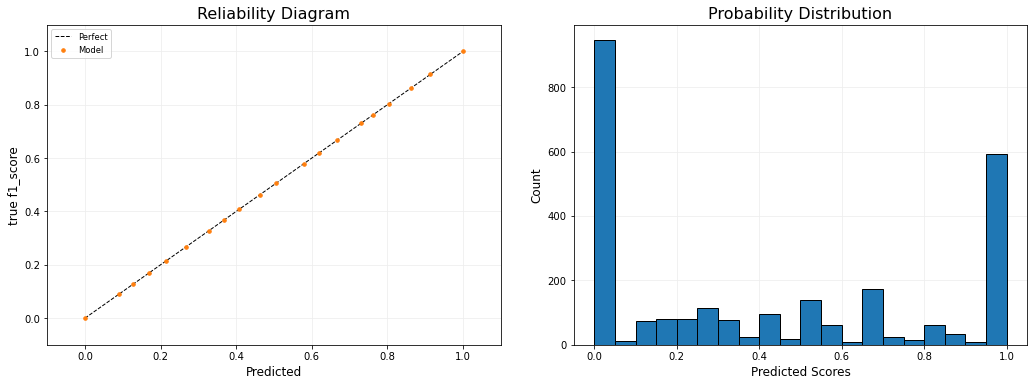

In [11]:
# Distribution of the f1 scores
plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y=y_train, x=y_train, **mli_reliability_kwargs);

###  Before calibration

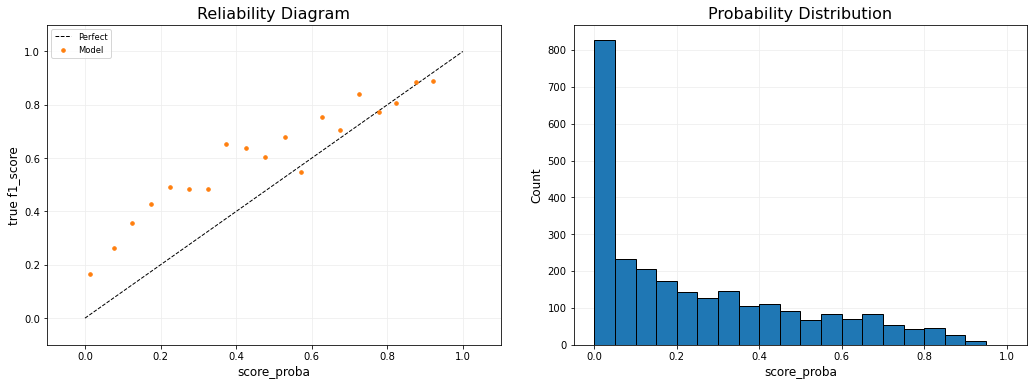

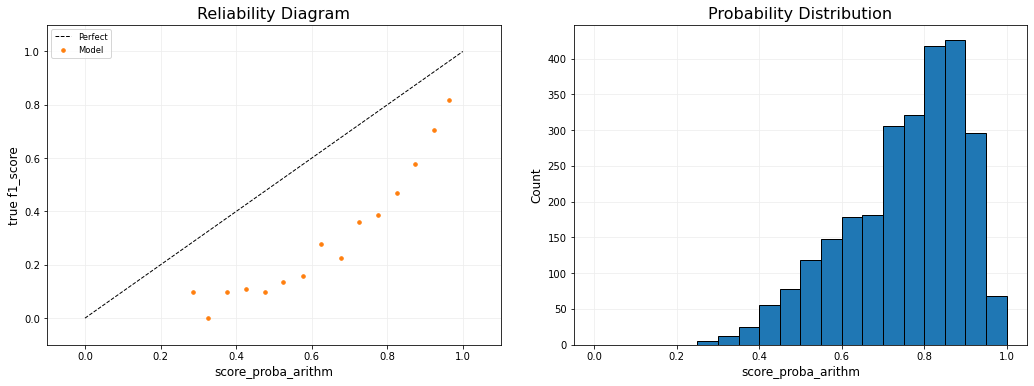

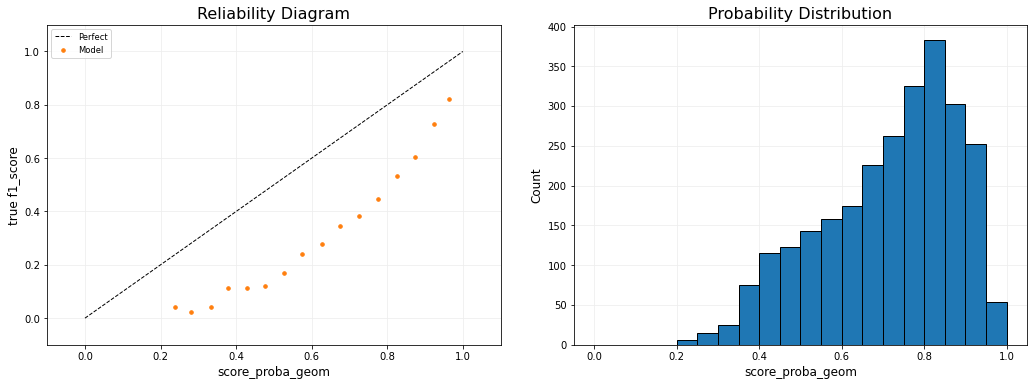

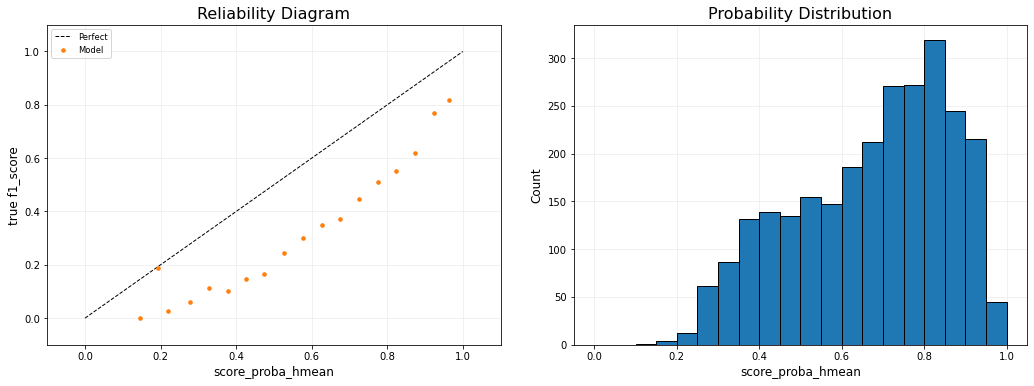

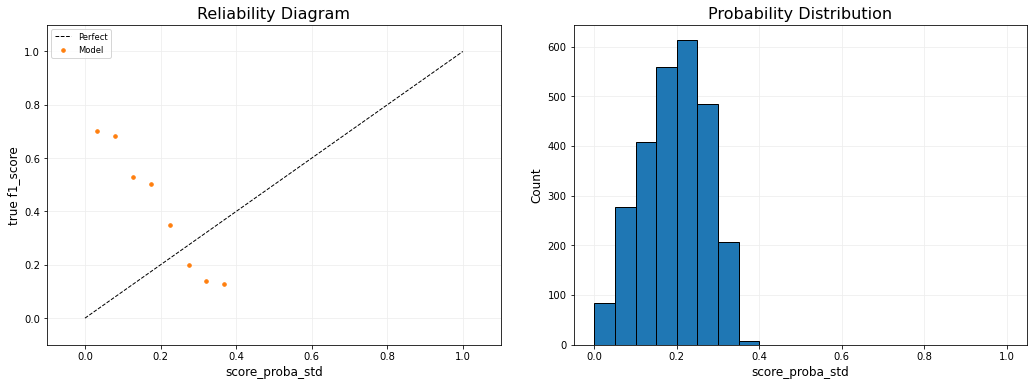

In [12]:
for col in UNCALIBRATED_SCORE_COLS:
    col_kwargs = mli_reliability_kwargs.copy()
    col_kwargs.update({
        "ax1_y_title": f"true {CALIBRATION_TARGET}",
        "ax1_x_title": f"{col}",
        "ax2_x_title": f"{col}",
    })
    # Uncalibrated and calibrated values
    x = X_train[col]
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(y=y_train, x=x, **col_kwargs);

### Logistic Regression (continuous version) w/ MSE

In [13]:
def fit_model(X, y, col, target, model_classpath, model_hyperparams, figname):
    model = model_classpath(**model_hyperparams)
    
    assert len(X.shape) == 1 and len(y.shape) == 1, "This is a 1-d logistic fit"
    model.fit(X, y)
    
    # -------------------------------------------------------------------
    # Observe the fit
    # -------------------------------------------------------------------
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    g = sns.jointplot(x=X, y=y)
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(target)
    # Plot decision boundary
    tvec = np.linspace(.01, .99, 99)
    sns.lineplot(tvec, model.predict(tvec), color="orange", ax=g.ax_joint, label=target);
    
    jointplot = f"{figname}_jointplot.svg"
    plt.savefig(jointplot, dpi=300)
    print("Saved figure at", jointplot)
    
    # -------------------------------------------------------------------
    # Reliability diagram
    # -------------------------------------------------------------------
    y_pred = model.predict(X)
    
    # Distribution of `target` in function of X
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(
        y=y, 
        x=y_pred, 
        ax1_x_title=f"predicted {target} ({col})",
        ax1_y_title=f"actual {target}",
        ax2_x_title=f"predicted {target} ({col})",
        error_bars=False, show_histogram=True,
    )
    rli = f"{figname}_reliability.svg"
    plt.savefig(rli, dpi=300)
    print("Saved figure at", rli)

    return model, y_pred

/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d_jointplot.svg
Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_arithm_f1_score_25c0eb505a113f402a6b483ca2c3b6c1_jointplot.svg
Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_arithm_f1_score_25c0eb505a113f402a6b483ca2c3b6c1_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_geom_f1_score_dc8d01381b41551f4f086dcc7f4055c7_jointplot.svg
Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_geom_f1_score_dc8d01381b41551f4f086dcc7f4055c7_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_hmean_f1_score_74d3a46eac3de1d9658bb4fc34212276_jointplot.svg
Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_hmean_f1_score_74d3a46eac3de1d9658bb4fc34212276_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_std_f1_score_dd726449fb8195c0997ed49e8f35f72a_jointplot.svg
Saved figure at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/logistic_mse_train_score_proba_std_f1_score_dd726449fb8195c0997ed49e8f35f72a_reliability.svg


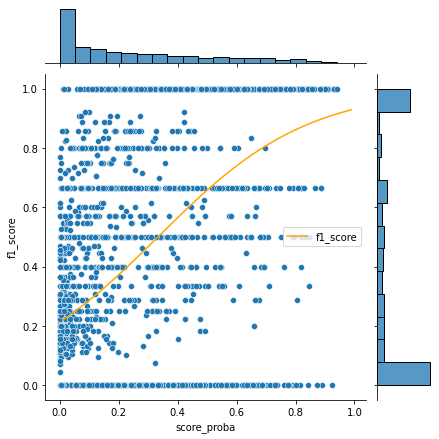

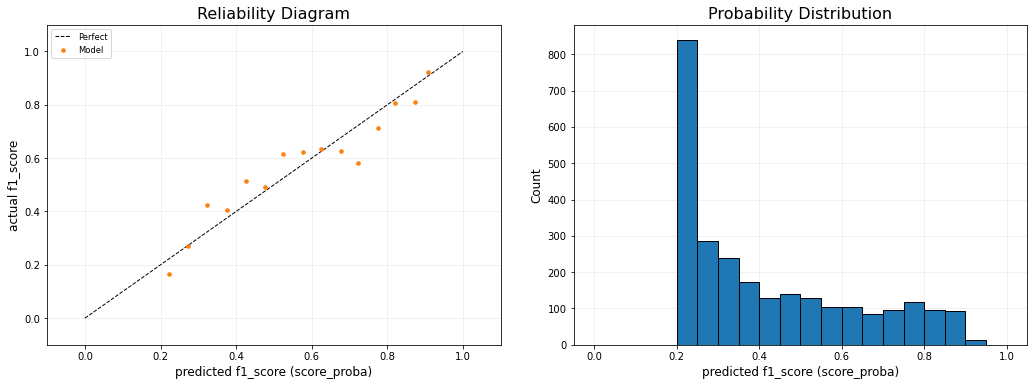

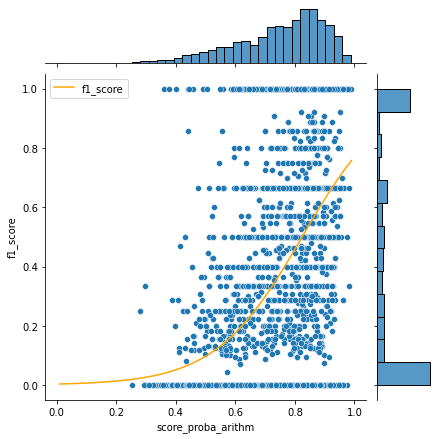

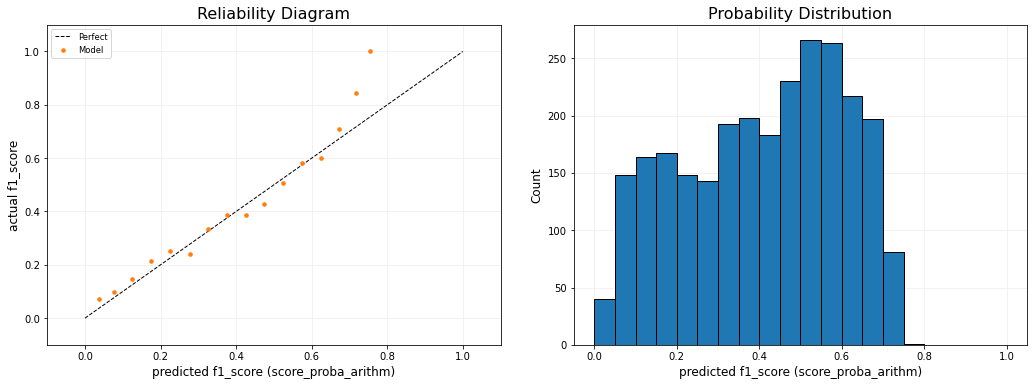

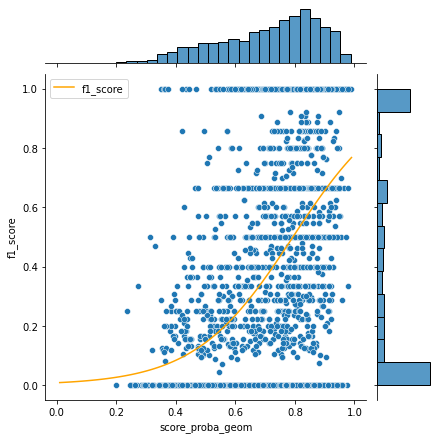

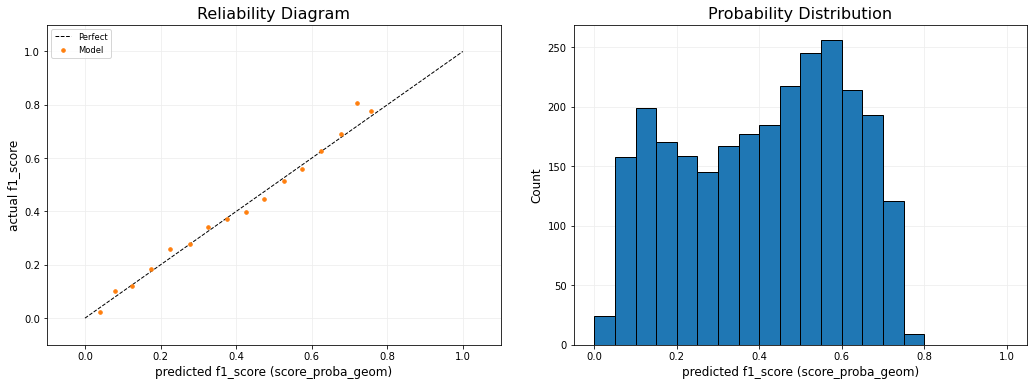

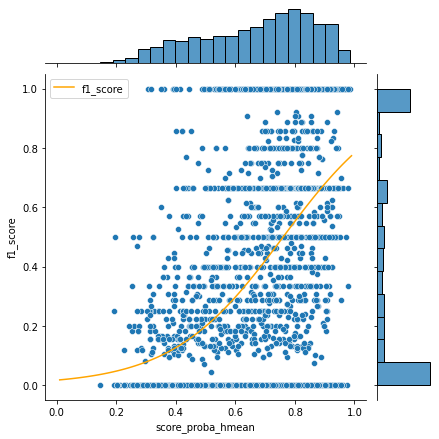

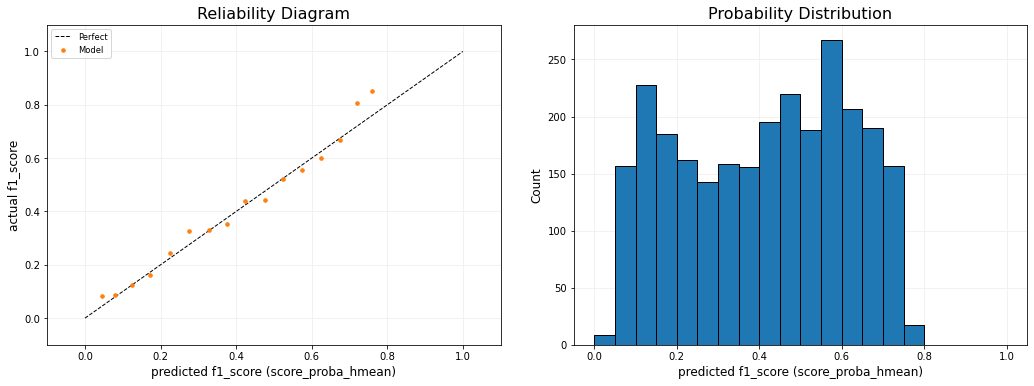

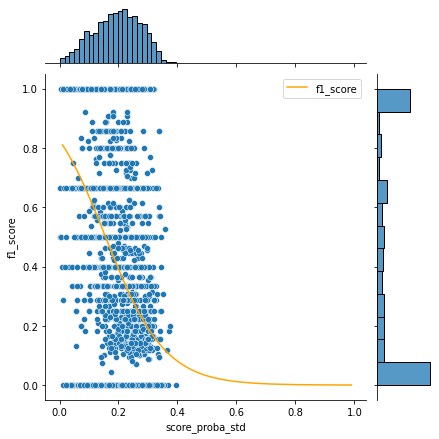

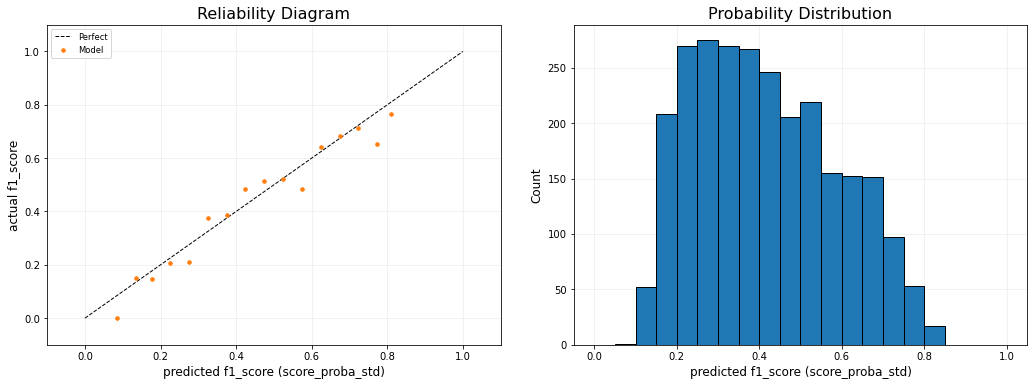

In [14]:
from functools import partial
from logistic import LogisticRegression
from utils_generic import method_name, generate_uuid


model_classpath = LogisticRegression
model_hyperparams = {}

# -------------------------------------------------------------------
#
# Fit LOGISTIC REGRESSION
# 
# -------------------------------------------------------------------
fit_logistic = partial(
    fit_model,
    model_classpath=model_classpath,
    model_hyperparams=model_hyperparams,
    target=CALIBRATION_TARGET,
)

results_metadata = {}
results_model = {}
results_preds = {}
for col in UNCALIBRATED_SCORE_COLS:
    features = sorted([col])
    
    calibrator_metadata = {
        "dataset_name": NORMALIZED_DATASET_NAME,
        "split_name": SPLIT_NAME,
        "preds_train_path": TRAIN_SET_PREDS_FILEPATH,
        "evals_train_path": TRAIN_SET_EVALS_FILEPATH,
        "model_classpath": method_name(model_classpath),
        "model_hyperparameters": model_hyperparams,
        "features": features,
        "features_uuid": generate_uuid(features),
        "target_metric": CALIBRATION_TARGET,
    }
    
    calibrator_uuid = generate_uuid(calibrator_metadata)
    calibrator_metadata["calibrator_uuid"] = calibrator_uuid
    
    name = f"logistic_mse_train_{col}_{CALIBRATION_TARGET}_{calibrator_uuid}"
    calibrator_metadata["name"] = name
    
    calibrator_figname = f"{CALIB_ROOT_DIR}/{name}"
    calibrator_metadata["calibrator_figname"] = calibrator_figname
    # Uncalibrated and calibrated values
    X = X_train[features].values.flatten()
    y = y_train.values.copy().flatten()
    
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    model, preds = fit_logistic(X=X, y=y, col=col, figname=calibrator_figname)
    
    results_model[col] = model
    results_preds[col] = preds
    results_metadata[col] = calibrator_metadata

#### Store model and calibrated predictions

In [15]:
from utils_generic import generate_uuid

import joblib
import yaml
import os


def store_calibration_results(parent_dir, data, preds: dict, models: dict, metadata: dict):
    preds_ext = ".csv.gz"
    model_ext = ".joblib"
    metadata_ext = "metadata.yaml"
    
    os.makedirs(f"{parent_dir}/preds", exist_ok=True)
    os.makedirs(f"{parent_dir}/models", exist_ok=True)
    
    keys = preds.keys()
    for key in keys:
        pred_key = preds[key]
        model_key = models[key]
        metadata_key = metadata[key]
        
        d = data.copy()
        d[key] = pred_key
        
        key_name = metadata_key["name"]
        preds_filepath = f"{parent_dir}/preds/{key_name}{preds_ext}"
        print("\nStoring predictions for", key_name, "with columns:", d.columns, "at", preds_filepath)
        d.to_csv(preds_filepath)
        
        model_filepath = f"{parent_dir}/models/{key_name}"
        print("\nStoring model pickle and meatadata for", key_name, "at", model_filepath)
        joblib.dump(model_key, model_filepath + model_ext)

        with open(model_filepath + metadata_ext, "w") as f:
            yaml.dump(metadata_key, f)
            
            
# Sanity check
store_calibration_results(
    CALIB_ROOT_DIR,
    data=pd.DataFrame(y_train),
    preds=results_preds,
    models=results_model,
    metadata=results_metadata,
 )


Storing predictions for logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d with columns: Index(['f1_score', 'score_proba'], dtype='object') at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/preds/logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d.csv.gz

Storing model pickle and meatadata for logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/models/logistic_mse_train_score_proba_f1_score_416d6c092bd41093132b9580849a7f4d

Storing predictions for logistic_mse_train_score_proba_arithm_f1_score_25c0eb505a113f402a6b483ca2c3b6c1 with columns: Index(['f1_score', 'score_proba_arithm'], dtype='object') at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/preds/logistic_mse_train_score_proba_arithm_f1_score_25c0eb505a113f402a6b483ca2c3b6c1.csv.gz

Storing model pickle and meatadata for logistic_mse_train_score_proba_arithm_f1_score_25c0eb

## Compute `Evals` in training


In [16]:
CALIB_EVALS_DIR = f"{CALIB_ROOT_DIR}/evals"
os.makedirs(CALIB_EVALS_DIR, exist_ok=True)


# Metrics to compute
CORR_METRICS_SUFFIX = "correlation_metrics"
CALIB_METRICS_SUFFIX = "calibration_metrics"
# ---------------------------------------------------------------------------------------------------
# 
# These files will contain the metrics concerning the different calibration techniques applied!
# 
# ---------------------------------------------------------------------------------------------------
# Name of the filepath to output the correlation metrics to
CALIBRATOR_TRAIN_CORR_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CORR_METRICS_SUFFIX}.csv"

# Name of the filepath to output the calibration metrics to
CALIBRATOR_TRAIN_CALIB_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CALIB_METRICS_SUFFIX}.csv"

!ls {CALIB_EVALS_DIR}

train_narrativeqa_test_5k_sample_seed_2022_calibration_metrics.csv
train_narrativeqa_test_5k_sample_seed_2022_correlation_metrics.csv



Just for a quick sanity check, the predicted distribution should be closer to the target metric `CALIBRATION_TARGET`, especially around the mean, since we're using the MSE (and the predictive mean is known to be the minimizer of the MSE).

- We note that the true distribution (`y_train`) has higher variance.
- Regardless of normalization scores, every distribution approximates the `mean`.
- None of these distributions is able to model values all way up to 1, i.e., maximum prediction is always below 1 (how will this affect user's confidence?, how is it compared with the OOD results?)

In [17]:
calibration_preds_df = pd.DataFrame(results_preds)
#calibration_preds_df[CALIBRATION_TARGET] = y_train.values
calibration_preds_df.index = X_train.index
pd.concat((calibration_preds_df, y_train), axis=1, names=list(calibration_preds_df.columns) + [CALIBRATION_TARGET]).describe()

,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std,f1_score
count,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000
mean,0.419993,0.407718,0.409357,0.410332,0.415244,0.412109
std,0.210476,0.191964,0.198277,0.202585,0.170756,0.399689
min,0.212918,0.019246,0.026308,0.035797,0.085651,0.000000
25%,0.232580,0.247078,0.235735,0.224460,0.274842,0.000000
50%,0.340507,0.433498,0.433624,0.429271,0.393888,0.307692
75%,0.573900,0.566845,0.575087,0.581029,0.539798,0.800000
max,0.914787,0.754456,0.764521,0.770485,0.824842,1.000000


In [18]:
TRAIN_SET_EVALS_FILEPATH

'../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/matrix/train_narrativeqa_test_5k_sample_seed_2022_evals_default.csv.gz'

In [19]:
# Calibration training evals (the metrics file used to retrieve the CALIBRATION_TARGET)
TRAIN_EVALS = pd.read_csv(TRAIN_SET_EVALS_FILEPATH).set_index(ID_COLS)
TRAIN_EVALS.tail()

,,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,meteor,metric_type
example_id,answer_id,,,,,,,,,,,,
579,0eab14cd84efc3f98aa178bd00a647b4,0,2.0,0.5,0.666667,0.571429,0.400000,0.571429,0.400000,0.571429,0.571429,0.604839,performance
2101,2e346f15f57ccf1894866af99777436f,0,0.0,0.5,0.200000,0.285714,0.166667,0.285714,0.000000,0.285714,0.285714,0.106383,performance
3703,d356380470a55a5fd4c2b43c5560cd0a,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,performance
846,9c3705372467a6ca5f8c0bd8a7a98f99,0,5.0,1.0,0.750000,0.857143,0.750000,0.857143,0.833333,0.857143,0.857143,0.754986,performance
3882,b375e40114d211928910251a63d07ec1,1,NaN,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.500000,performance


In [20]:
SCORE_COLS = UNCALIBRATED_SCORE_COLS
evals = TRAIN_EVALS.loc[X_train.index,:]
assert len(evals) == len(calibration_preds_df)

# This cell is copied from the notebook 4
import metrics as m

# Validation of the scores range
for col in SCORE_COLS:
    assert 0 <= min(calibration_preds_df[col]), f"{col} col is less than 0"
    assert max(calibration_preds_df[col]) <= 1, f"{col} col is greater than 1"

# Let us compute the
GLOBAL_METRICS = evals.join(calibration_preds_df, how="left")
GLOBAL_METRICS.head()

,,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,meteor,metric_type,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
example_id,answer_id,,,,,,,,,,,,,,,,,
4089,20f31e64728dd5ea219a0b78d86ca9c5,0,1.0,0.166667,0.076923,0.105263,0.055556,0.105263,0.0,0.105263,0.105263,0.081301,performance,0.212972,0.095872,0.096097,0.104543,0.235980
649,526096c66e8aa6a022d52f765a1788d6,1,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.500000,performance,0.836664,0.703262,0.714594,0.721652,0.644783
1267,6b229aa481e0b9cc4803d96006a6da82,1,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.500000,performance,0.906247,0.732485,0.745428,0.753820,0.765457
1363,aba825af9ad045bdacf00534986726d4,1,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.981481,performance,0.704946,0.680704,0.695649,0.705870,0.653180
2841,26c8771a08382a25f6862716fca035c0,0,1.0,0.333333,0.100000,0.153846,0.083333,0.153846,0.0,0.153846,0.153846,0.053763,performance,0.281361,0.504387,0.463359,0.399540,0.286607


In [21]:
REFERENCE_METRICS = [CALIBRATION_TARGET] 

# -----------------------------------------------------------------
GLOBAL_METRICS = GLOBAL_METRICS.reset_index()
print("Before de-duplication of data:", len(GLOBAL_METRICS))

_temp = GLOBAL_METRICS.sort_values(REFERENCE_METRICS, ascending=False)
GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)

print("After de-duplication of data:", len(GLOBAL_METRICS_UNIQUE))
# -----------------------------------------------------------------
GLOBAL_METRICS_UNIQUE.info()

Before de-duplication of data: 2639
After de-duplication of data: 2639
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2639 entries, (4089, '20f31e64728dd5ea219a0b78d86ca9c5') to (3882, 'b375e40114d211928910251a63d07ec1')
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   exact_match           2639 non-null   int64  
 1   first_error_position  2046 non-null   float64
 2   precision             2639 non-null   float64
 3   recall                2639 non-null   float64
 4   f1_score              2639 non-null   float64
 5   csi                   2639 non-null   float64
 6   rouge1                2639 non-null   float64
 7   rouge2                2639 non-null   float64
 8   rougeL                2639 non-null   float64
 9   rougeLsum             2639 non-null   float64
 10  meteor                2639 non-null   float64
 11  metric_type           2639 non-null   object 
 12  score_proba           26

/tmp/ipykernel_213329/4102815749.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)


### Correlation metrics

In [22]:
corr_metrics = []
for score_col in SCORE_COLS:
    print(score_col)
    score_col_results = m.CorrelationMetric(score_col).compute(GLOBAL_METRICS_UNIQUE, REFERENCE_METRICS)
    score_col_results = score_col_results.dropna()
    corr_metrics.append(score_col_results)
    
corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
corr_metrics

score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std


,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.522787,4.620601e-185,0.497251,7.106624e-165,0.364504,1.060531e-149,correlation
1,f1_score,score_proba_arithm,0.474038,5.914694e-148,0.465895,2.538703e-142,0.344365,7.847537e-134,correlation
2,f1_score,score_proba_geom,0.495179,2.603338e-163,0.483472,1.129284e-154,0.357906,2.107008e-144,correlation
3,f1_score,score_proba_hmean,0.508332,2.007367e-173,0.494094,1.698551e-162,0.366079,5.579893e-151,correlation
4,f1_score,score_proba_std,0.427558,9.128438e-118,0.407815,2.644327e-106,0.300741,1.539719e-102,correlation


In [23]:
print("Storing correlation metrics at", CALIBRATOR_TRAIN_CORR_METRICS)
corr_metrics.to_csv(f"{CALIBRATOR_TRAIN_CORR_METRICS}", index=False)

Storing correlation metrics at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/evals/train_narrativeqa_test_5k_sample_seed_2022_correlation_metrics.csv


### Calibration metrics


Amongst the calibration metrics, we have `expected calibration error (ECE)`, `brier score`, `AUC` which quantify the absolute and relative calibrations measures. 


In [24]:
CALIB_METRICS = [CALIBRATION_TARGET]

In [25]:
calib_metrics = []
for calib_metric in CALIB_METRICS:
    calib_results = m.CalibrationMetrics(calib_metric).compute(GLOBAL_METRICS_UNIQUE, SCORE_COLS)
    calib_results = calib_results.dropna()
    
    calib_metrics.append(calib_results)
    
calib_metrics = pd.concat(calib_metrics, axis=0)
calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.116111,0.286363,0.007884,0.340660,0.053877,0.018464,0.051654,0.008844,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.123832,0.295688,-0.004391,0.351870,0.028888,0.003985,0.021926,0.005808,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.120542,0.291113,-0.002752,0.347181,0.017583,0.003929,0.018913,0.005888,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.118430,0.287969,-0.001776,0.344132,0.021366,0.005035,0.023887,0.006710,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.130508,0.309399,0.003136,0.361246,0.037202,0.006930,0.032627,0.006024,"{'n_bins': 20, 'frac': 0.1}",calibration


In [26]:
print("Storing calibration metrics at", CALIBRATOR_TRAIN_CALIB_METRICS)
calib_metrics.describe().to_csv(CALIBRATOR_TRAIN_CALIB_METRICS, index=False)

Storing calibration metrics at ../outputs/results/narrativeqa/test_5k_sample_seed_2022/calib/evals/train_narrativeqa_test_5k_sample_seed_2022_calibration_metrics.csv


## Evaluation in `test_set`

In [28]:
def evaluate(X, y, models_dict, target, figname):
    X_data, y_data = X.copy(), y.copy()
    models_preds = {}
    for col, model in models_dict.items():
        print(col, figname)
        X = X_data[col].values.flatten()
        y = y_data.values.flatten()
        assert len(X.shape) == 1 and len(y.shape) == 1, "This is a 1-d logistic fit"

        # -------------------------------------------------------------------
        # Observe the fit
        # -------------------------------------------------------------------
        # We re-use the same structure as the preds we've loaded initially
        # write them into a calibrated predictions file.
        g = sns.jointplot(x=X, y=y)
        g.ax_joint.set_xlabel(col)
        g.ax_joint.set_ylabel(target)
        # Plot decision boundary
        tvec = np.linspace(.01, .99, 99)
        sns.lineplot(tvec, model.predict(tvec), color="orange", ax=g.ax_joint, label=target);

        jointplot = f"{figname}_{col}_jointplot.svg"
        plt.savefig(jointplot, dpi=300)
        print("Saved figure at", jointplot)

        # -------------------------------------------------------------------
        # Reliability diagram
        # -------------------------------------------------------------------
        y_pred = model.predict(X)

        # Distribution of `target` in function of X
        plt.figure(figsize=(15, 6));
        mli.plot_reliability_diagram(
            y=y, 
            x=y_pred, 
            ax1_x_title=f"predicted {target} ({col})",
            ax1_y_title=f"actual {target}",
            ax2_x_title=f"predicted {target} ({col})",
            error_bars=False, show_histogram=True,
        )
        rli = f"{figname}_{col}_reliability.svg"
        plt.savefig(rli, dpi=300)
        print("Saved figure at", rli)
        models_preds[col] = y_pred
        
    return models_preds

In [29]:
def get_path(matrix_type, dataset_name, split_name, tokenizer="default", parent_dir=OUTPUT_DIR):
    assert matrix_type in ("train", "test")
    
    if isinstance(dataset_name, tuple):
        normalized_dataset_name = "".join(DATASET_NAME)
    else:
        normalized_dataset_name = dataset_name
        
    base_filename = f"{normalized_dataset_name}_{split_name}"
    base_dir = f"{parent_dir}/results/{normalized_dataset_name}/{split_name}" 
    
    calib_dir = f"{base_dir}/calib/matrix"
    calib_preds_path = f"{calib_dir}/{matrix_type}_{base_filename}_scores.csv.gz"
    calib_evals_path = f"{calib_dir}/{matrix_type}_{base_filename}_evals_{tokenizer}.csv.gz"
    
    return calib_preds_path, calib_evals_path, f"{matrix_type}_{base_filename}"

In [84]:
# DATASET_NAME, SPLIT_NAME = "squad", "validation"
# DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
DATASETS_SPLITS = [
    ("squad", "validation"),
    ("newsqa", "dev"),
    #  (('squadshifts', 'new_wiki'), "test"),
    ("narrativeqa", "test_5k_sample_seed_2022"),
]


def evaluate_datasets(datasets_splits, matrix_type, models, target):
    for dataset_name, split_name in datasets_splits:
        print("\n\n# -------------------------------------------------------------------------------------------------------------- #")
        print(f"#\t\t\t {NORMALIZED_DATASET_NAME} ({SPLIT_NAME}) ---> {dataset_name} ({split_name})")
        print("# -------------------------------------------------------------------------------------------------------------- #")
        pred_path, eval_path, base_filename = get_path(matrix_type, dataset_name, split_name)

        X, y = get_dataset_for_calibration(
            pred_path, 
            eval_path, 
            id_cols=ID_COLS,
            **csv_kwargs,
        )

        X_train = X[UNCALIBRATED_SCORE_COLS]
        y_train = y[CALIBRATION_TARGET]
        print("Evaluate in training set for dataset:", dataset_name, split_name)
        yield X, y, evaluate(X_train, y_train, models, target=target, figname=base_filename)

        
        
def evaluate_metrics(global_metrics: pd.DataFrame, score_cols: list, target=CALIBRATION_TARGET, id_cols=ID_COLS):
    # Validation of the scores range
    for col in score_cols:
        assert 0 <= min(global_metrics[col]), f"{col} col is less than 0"
        assert max(global_metrics[col]) <= 1, f"{col} col is greater than 1"

    # Let us compute the    
    ref_metrics = [target]
    
    corr_metrics = []
    for score_col in SCORE_COLS:
        print(score_col)
        score_col_results = m.CorrelationMetric(score_col).compute(global_metrics, ref_metrics)
        score_col_results = score_col_results.dropna()
        corr_metrics.append(score_col_results)

    corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
    
    calib_metrics = []
    for calib_metric in ref_metrics:
        calib_results = m.CalibrationMetrics(calib_metric).compute(global_metrics, score_cols)
        calib_results = calib_results.dropna()

        calib_metrics.append(calib_results)

    calib_metrics = pd.concat(calib_metrics, axis=0)

    return corr_metrics, calib_metrics

In [100]:
train_evaluations = evaluate_datasets(DATASETS_SPLITS, matrix_type="train", models=results_model, target=CALIBRATION_TARGET)
test_evaluations = evaluate_datasets(DATASETS_SPLITS, matrix_type="test", models=results_model, target=CALIBRATION_TARGET)

### Train evaluations for 



# -------------------------------------------------------------------------------------------------------------- #
#			 narrativeqa (test_5k_sample_seed_2022) ---> newsqa (dev)
# -------------------------------------------------------------------------------------------------------------- #
Loading predictions from ../outputs/results/newsqa/dev/calib/matrix/train_newsqa_dev_scores.csv.gz
Loading evaluation metrics from ../outputs/results/newsqa/dev/calib/matrix/train_newsqa_dev_evals_default.csv.gz
Considering features: None
Considering target: None
Evaluate in training set for dataset: newsqa dev
score_proba train_newsqa_dev


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_newsqa_dev_score_proba_jointplot.svg
Saved figure at train_newsqa_dev_score_proba_reliability.svg
score_proba_arithm train_newsqa_dev


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_newsqa_dev_score_proba_arithm_jointplot.svg
Saved figure at train_newsqa_dev_score_proba_arithm_reliability.svg
score_proba_geom train_newsqa_dev


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_newsqa_dev_score_proba_geom_jointplot.svg
Saved figure at train_newsqa_dev_score_proba_geom_reliability.svg
score_proba_hmean train_newsqa_dev


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_newsqa_dev_score_proba_hmean_jointplot.svg
Saved figure at train_newsqa_dev_score_proba_hmean_reliability.svg
score_proba_std train_newsqa_dev


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_newsqa_dev_score_proba_std_jointplot.svg
Saved figure at train_newsqa_dev_score_proba_std_reliability.svg
score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std
score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std


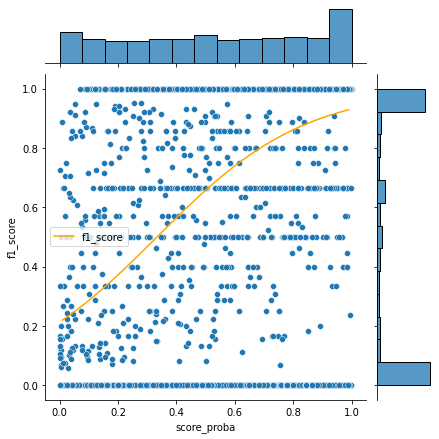

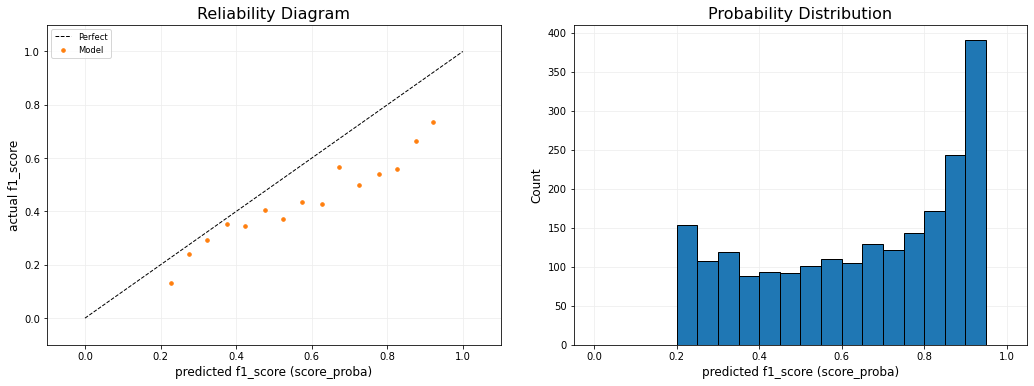

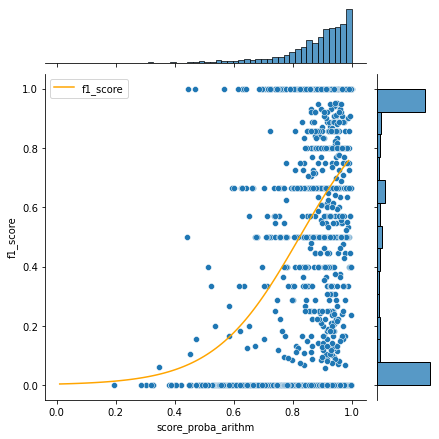

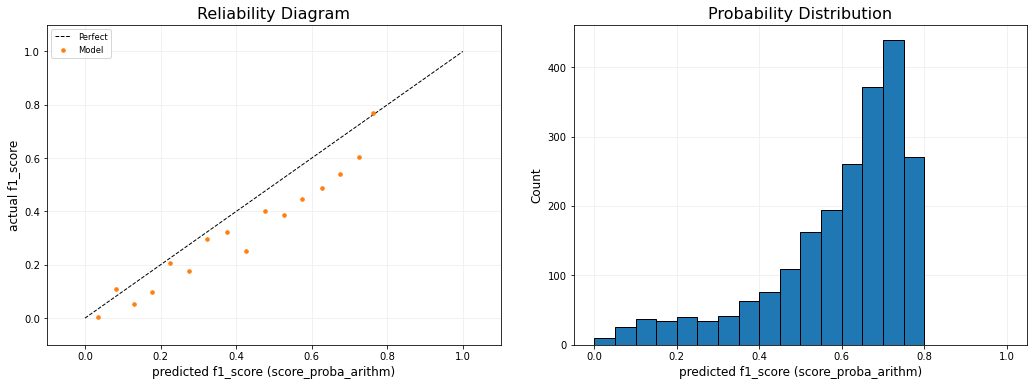

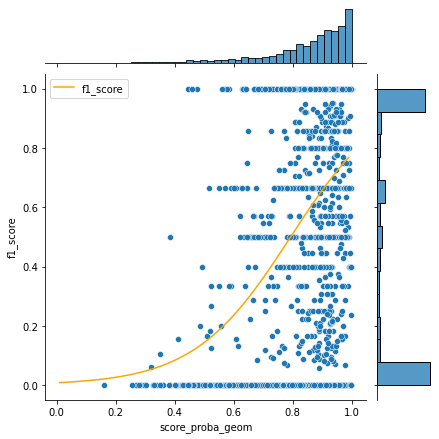

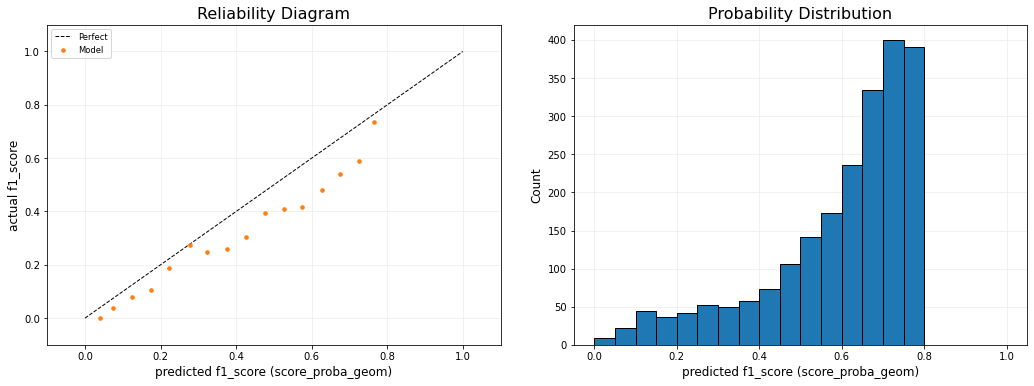

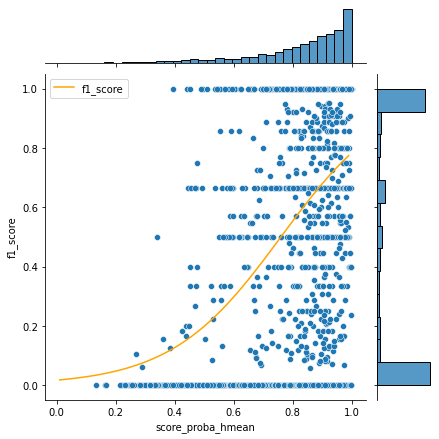

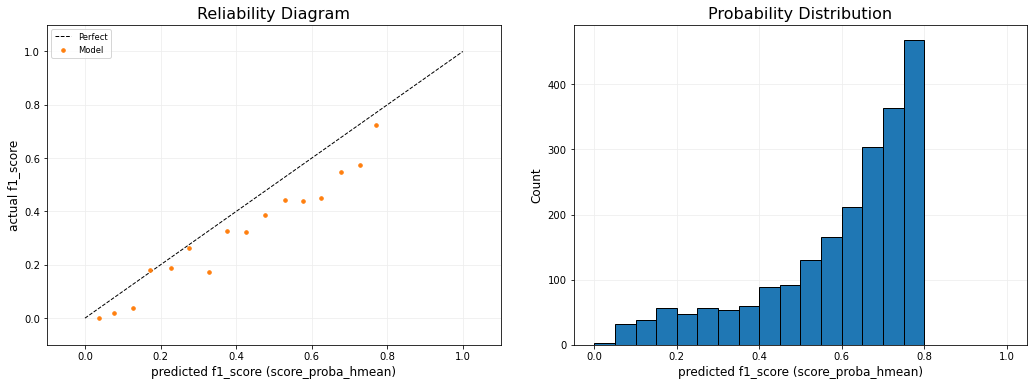

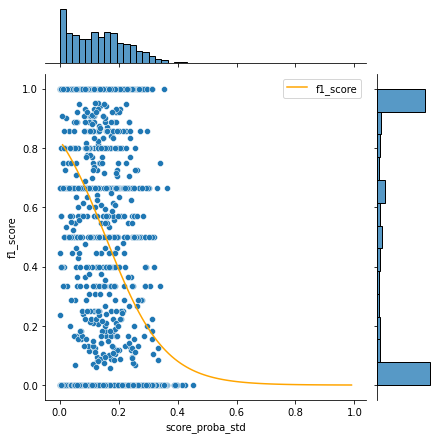

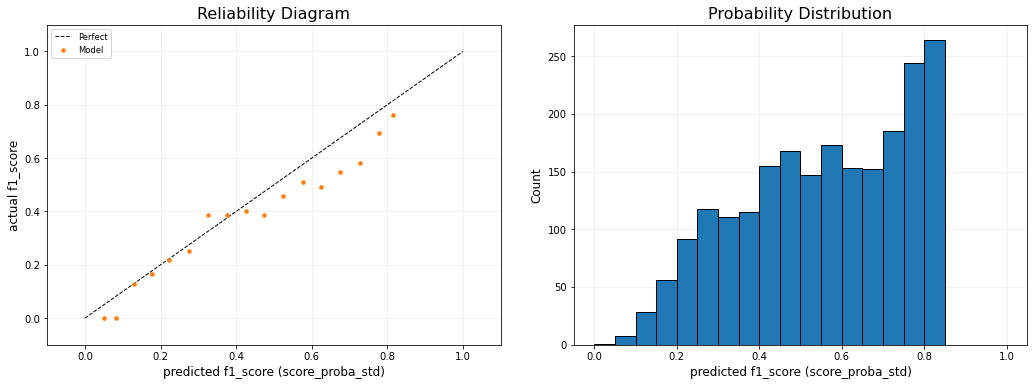

In [102]:
X_calib, y_calib, models = next(train_evaluations)


# Before calibration
uncalib_global_metrics = y_calib.join(X_calib, how="left")
uncalib_corr_metrics, uncalib_calib_metrics = evaluate_metrics(
    global_metrics=uncalib_global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)


# After calibration
preds_df = pd.DataFrame(models)
preds_df.index = y_calib.index

global_metrics = y_calib.join(preds_df, how="left")
calib_corr_metrics, calib_calib_metrics = evaluate_metrics(
    global_metrics=global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)

In [94]:
uncalib_global_metrics.describe()

,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,meteor,preds_raw_count,truncated,score_proba,score_proba_arithm,score_proba_std,score_proba_geom,score_proba_hmean
count,2639.000000,2046.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.0,2.639000e+03,2639.000000,2639.000000,2639.000000,2639.000000
mean,0.224706,0.305963,0.442649,0.426836,0.412109,0.357392,0.412109,0.191654,0.408717,0.408717,0.323879,6.191739,1.0,2.470847e-01,0.752646,0.194503,0.714342,0.672244
std,0.417468,0.756542,0.423280,0.418953,0.399689,0.394877,0.399689,0.347595,0.399058,0.399058,0.343623,4.373441,0.0,2.466987e-01,0.143881,0.076949,0.164160,0.187232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.729614e-10,0.252072,0.000634,0.200014,0.146477
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0,2.899199e-02,0.661946,0.140046,0.600120,0.529355
50%,0.000000,0.000000,0.333333,0.333333,0.307692,0.181818,0.307692,0.000000,0.300000,0.300000,0.178571,5.000000,1.0,1.649275e-01,0.785146,0.199275,0.749501,0.707418
75%,0.000000,0.000000,1.000000,1.000000,0.800000,0.666667,0.800000,0.250000,0.800000,0.800000,0.500000,8.000000,1.0,4.095729e-01,0.863225,0.253356,0.843112,0.821490
max,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999314,36.000000,1.0,9.392078e-01,0.987424,0.393546,0.986885,0.986317


In [95]:
global_metrics.describe()

,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,meteor,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
count,2639.000000,2046.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000
mean,0.224706,0.305963,0.442649,0.426836,0.412109,0.357392,0.412109,0.191654,0.408717,0.408717,0.323879,0.419993,0.407718,0.409357,0.410332,0.415244
std,0.417468,0.756542,0.423280,0.418953,0.399689,0.394877,0.399689,0.347595,0.399058,0.399058,0.343623,0.210476,0.191964,0.198277,0.202585,0.170756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212918,0.019246,0.026308,0.035797,0.085651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232580,0.247078,0.235735,0.224460,0.274842
50%,0.000000,0.000000,0.333333,0.333333,0.307692,0.181818,0.307692,0.000000,0.300000,0.300000,0.178571,0.340507,0.433498,0.433624,0.429271,0.393888
75%,0.000000,0.000000,1.000000,1.000000,0.800000,0.666667,0.800000,0.250000,0.800000,0.800000,0.500000,0.573900,0.566845,0.575087,0.581029,0.539798
max,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999314,0.914787,0.754456,0.764521,0.770485,0.824842


### Uncalibrated metrics

In [96]:
# Regarding the uncalibrated dataset
uncalib_corr_metrics

,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.523394,1.457929e-185,0.497251,7.106624e-165,0.364504,1.060531e-149,correlation
1,f1_score,score_proba_arithm,0.460986,5.341997e-139,0.465895,2.538703e-142,0.344365,7.847537e-134,correlation
2,f1_score,score_proba_geom,0.487124,2.478569e-157,0.483472,1.129284e-154,0.357906,2.107008e-144,correlation
3,f1_score,score_proba_hmean,0.502953,3.106152e-169,0.494094,1.698551e-162,0.366079,5.579893e-151,correlation
4,f1_score,score_proba_std,-0.428141,4.076406e-118,-0.407815,2.644327e-106,-0.300741,1.539719e-102,correlation


In [97]:
calib_corr_metrics

,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.522787,4.620601e-185,0.497251,7.106624e-165,0.364504,1.060531e-149,correlation
1,f1_score,score_proba_arithm,0.474038,5.914694e-148,0.465895,2.538703e-142,0.344365,7.847537e-134,correlation
2,f1_score,score_proba_geom,0.495179,2.603338e-163,0.483472,1.129284e-154,0.357906,2.107008e-144,correlation
3,f1_score,score_proba_hmean,0.508332,2.007367e-173,0.494094,1.698551e-162,0.366079,5.579893e-151,correlation
4,f1_score,score_proba_std,0.427558,9.128438e-118,0.407815,2.644327e-106,0.300741,1.539719e-102,correlation


In [98]:
uncalib_calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.144584,0.295541,-0.165024,0.342566,0.167412,0.046914,0.165024,0.025856,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.243351,0.415164,0.340538,0.356910,0.340538,0.056242,0.340538,0.041545,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.214075,0.387622,0.302233,0.350329,0.302233,0.042367,0.302233,0.035156,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.187156,0.360408,0.260136,0.345667,0.260136,0.032590,0.260136,0.030961,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.239288,0.391506,-0.217605,0.438105,0.274284,0.069629,0.274409,0.063126,"{'n_bins': 20, 'frac': 0.1}",calibration


In [99]:
calib_calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.116111,0.286363,0.007884,0.340660,0.053877,0.018464,0.051654,0.008844,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.123832,0.295688,-0.004391,0.351870,0.028888,0.003985,0.021926,0.005808,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.120542,0.291113,-0.002752,0.347181,0.017583,0.003929,0.018913,0.005888,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.118430,0.287969,-0.001776,0.344132,0.021366,0.005035,0.023887,0.006710,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.130508,0.309399,0.003136,0.361246,0.037202,0.006930,0.032627,0.006024,"{'n_bins': 20, 'frac': 0.1}",calibration


### Calib metrics

In [ ]:
### Test evaluations

In [ ]:
X, y, models = next(test_evaluations)

preds_df = pd.DataFrame(models)
preds_df.index = y.index

global_metrics = y.join(preds_df, how="left")
corr_metrics, calib_metrics = evaluate_metrics(
    global_metrics=global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)

In [ ]:
next(evaluations)